# Create a Hierarchical Model

*For this tutorial, we are going to be using the project 'Gesture Demo' which you can find at https://sensiml.com/documentation/_static/file/gesture-demo.zip*

The Knowledge Pack library we create can be a combination of several Knowledge Packs that you have already built. In fact, it can have an arbitrary number of different models so long as the device you are using has enough space to use them. In this tutorial we give an example of building a hierarchical model using the gesture data. This model will consist of 3 models in total with the goal of predicting gestures A, D, M, L and U from the gesture project. In the Parent Model we will separate our data into two groups, AD and MLU and build a model that can make a prediction as to which group they are in. Then we will build a model that can tell the difference between A and D, and a third model that will distinguish between M, L and U. The binary we create will optimize the Knowledge Pack to reuse code and resources where possible combining all three models in a decision tree structure.

# Connect to Server

In [12]:
import sys
from sensiml import SensiML
import pandas as pd
import numpy as np
client = SensiML()

client.project = 'Gesture Demo'
client.pipeline = "Hierarchical Pipeline"

## Create a query for each node model

To select the data you want to use in your pipeline you need to add a query step. Queries give us a way to select and filter the data we want to use in our pipeline. We recommend using the Prepare Data page in the Analytics Studio at https://app.sensiml.cloud/ to create queries, but in this tutorial we will be using the create_query API.

Let's create a query for each of the nodes in our model

* Create a query that selects A,D,L,M,U. 
* Create a query that selects A,D
* Create a query that selects L,M,U

Create a name for your query that is meaningful to the type of data you are going to pull in. For example 'Gesture Query - ADMLU'

In [ ]:
client.create_query(name="Gesture Query - ADMLU",
                 segmenter="My Auto Session",
                 label_column="Label",
                 metadata_columns=["Subject"],
                 columns=["AccelerometerX","AccelerometerY","AccelerometerZ","GyroscopeX","GyroscopeY","GyroscopeZ"],
                 metadata_filter="[Label] in [A,D,L,M,U]"
                )

# Create Parent Model

## Generate Feature Vectors for the selected Query

In [93]:
client.pipeline.reset()

client.pipeline.set_input_query("Gesture Query - ADMLU")

client.pipeline.add_transform("Magnitude", params={"input_columns":[u'AccelerometerX', u'AccelerometerZ']}, overwrite=False)

sensor_columns = [u'AccelerometerY', u'AccelerometerX', u'AccelerometerZ', u'GyroscopeX', u'GyroscopeY', u'GyroscopeZ',
                 u'Magnitude_ST_0000']

client.pipeline.add_feature_generator([ {'subtype_call': 'Time', 'params': {'sample_rate': 100}},
                                            {'subtype_call': 'Rate of Change'},
                                            {'subtype_call': 'Statistical'},
                                            {'name':'Downsample with Min Max Scaling', 'params':{"columns": sensor_columns, "new_length": 9}},
                                            ],
                                            function_defaults={'columns': sensor_columns},
                                           )

client.pipeline.add_transform("Min Max Scale", params={"min_bound":0, "max_bound":255, "pad":2})

## Combine Features into sub groups for prediction

Here we will combine our 5 features into two groups to make predictions on. In group one we will combine the segments from A,D and in group 2 we will combine the segments M, U and L. Afterwards we will apply a series of feature selectors to reduce the number of features to the most relevent/separable.

In [94]:
client.pipeline.add_transform("Combine Labels", params={"combine_labels": {'Group1':['A','D'],'Group2':['M','U','L']}})

In [95]:
client.pipeline.add_feature_selector([{'name':'Information Gain', 'params':{"feature_number": 2, "target_sensor_weight": 0.9}},
                                   {'name':'Recursive Feature Elimination', 'params':{"method":"Log R", "number_of_features":8}}
                                  ],
                                  params = {"number_of_features":4})

Executing Pipeline with Steps:

------------------------------------------------------------------------
 0.     Name: Gesture Query - ADMLU     		Type: query                    
------------------------------------------------------------------------
------------------------------------------------------------------------
 1.     Name: Magnitude                 		Type: transform                
------------------------------------------------------------------------
------------------------------------------------------------------------
 2.     Name: generator_set             		Type: generatorset             
------------------------------------------------------------------------
------------------------------------------------------------------------
 3.     Name: Min Max Scale             		Type: transform                
------------------------------------------------------------------------
------------------------------------------------------------------------
 4.     Name: C

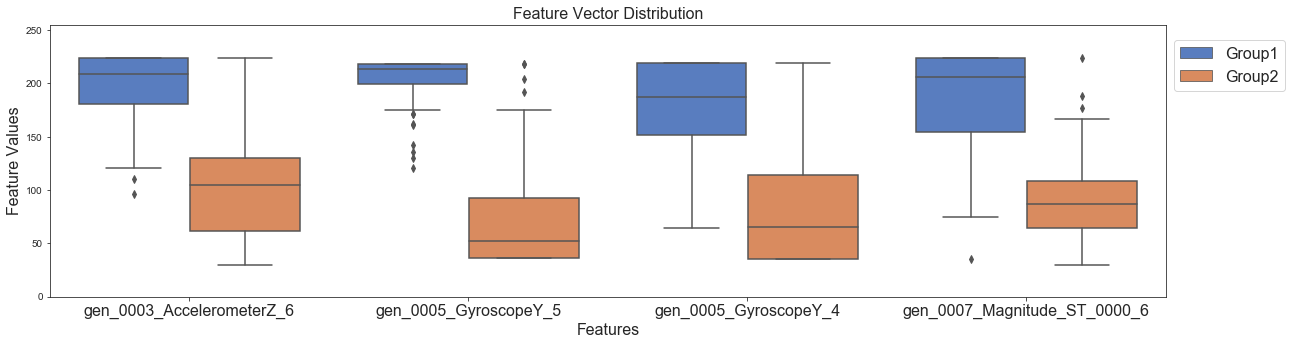

In [96]:
features, s = client.pipeline.execute()
client.pipeline.visualize_features(feature_vector=features)

## Build a model using KNN

We will now build a model to recognize these two classes. We will use the KNN classifier which will always return the closest result. Unlike RBF, which will only return results within the AIF distance otherwise it returns unknown.

In [97]:
client.pipeline.set_classifier("PME", params={"distance_mode":"L1", "classification_mode":"KNN", "max_aif":156, "min_aif":5})
client.pipeline.set_validation_method("Stratified K-Fold Cross-Validation", params={"number_of_folds": 4})
client.pipeline.set_training_algorithm("Hierarchical Clustering with Neuron Optimization", params={"number_of_neurons":46})
client.pipeline.set_tvo({'validation_seed':0})

r,s = client.pipeline.execute()
parent_model = r.configurations[0].models[0]
r.summarize()

Executing Pipeline with Steps:

------------------------------------------------------------------------
 0.     Name: Gesture Query - ADMLU     		Type: query                    
------------------------------------------------------------------------
------------------------------------------------------------------------
 1.     Name: Magnitude                 		Type: transform                
------------------------------------------------------------------------
------------------------------------------------------------------------
 2.     Name: generator_set             		Type: generatorset             
------------------------------------------------------------------------
------------------------------------------------------------------------
 3.     Name: Min Max Scale             		Type: transform                
------------------------------------------------------------------------
------------------------------------------------------------------------
 4.     Name: C

## Visualize the features and neuron placement

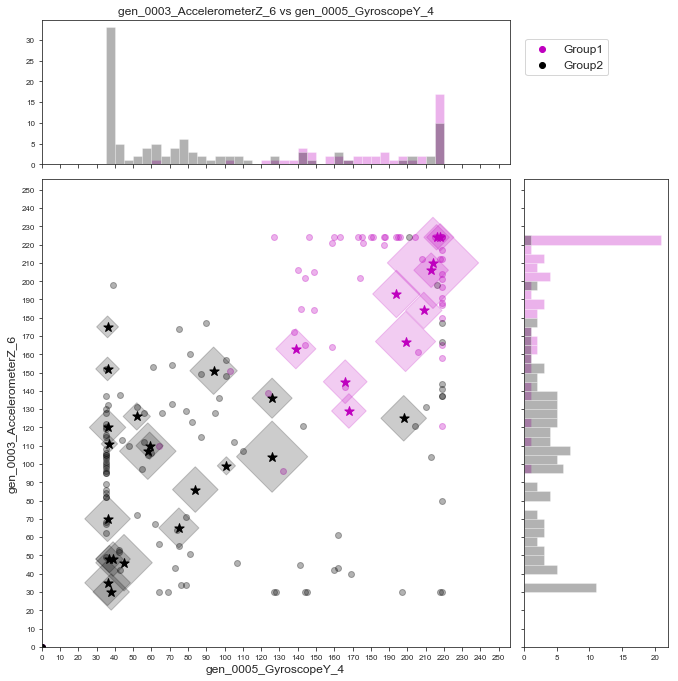

In [98]:
client.pipeline.visualize_neuron_array(parent_model, features, pd.DataFrame(parent_model.knowledgepack.feature_summary).Feature.values[0], pd.DataFrame(parent_model.knowledgepack.feature_summary).Feature.values[1])

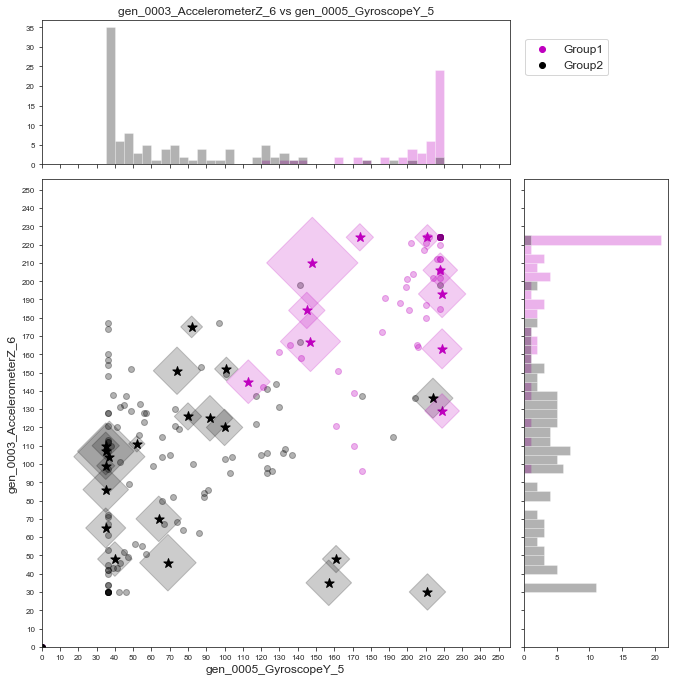

In [99]:
client.pipeline.visualize_neuron_array(parent_model, features, pd.DataFrame(parent_model.knowledgepack.feature_summary).Feature.values[0], pd.DataFrame(parent_model.knowledgepack.feature_summary).Feature.values[2])

## Test the Knowledge Pack against a capture file

Because we have grouped our data into two categories. We would expect any gesture that is A or D to return classification 1, and any gesture that is M,U or L to be recognized as classification 2. Let us check that this is the case with one of our files captured previously in the DCL.

In [100]:
client.list_captures().head()

,Name
0,Subject4_Event_U.csv
1,Subject4_Event_M.csv
2,Subject4_Event_L.csv
3,Subject4_Event_D.csv
4,Subject4_Event_A.csv


In [101]:
rr,ss = parent_model.knowledgepack.recognize_signal(capture="User004_M.csv")
rr


Checking Pipeline Status:


Status: Running  Time:   0 sec.   .

Results Retrieved... Execution Time: 0 min. 30 sec.
Results retrieved.


,DistanceVector,NIDVector,CategoryVector,MappedCategoryVector,SegmentID
0,[140],[26],[2],[Group2],0
1,[55],[14],[2],[Group2],1
2,[178],[23],[1],[Group1],2
3,[29],[7],[2],[Group2],3
4,[84],[8],[2],[Group2],4
5,[19],[9],[2],[Group2],5
6,[55],[7],[2],[Group2],6
7,[25],[7],[2],[Group2],7
8,[11],[7],[2],[Group2],8
9,[100],[9],[2],[Group2],9


## Save the Knowledge Pack

In [102]:
parent_model.knowledgepack.save('Parent-ADMLU')

Knowledgepack name updated.


# Create Submodel A,D


## Generate features for A and D events
Create a query for selecting only the A and D events

In [ ]:
client.create_query(name="AD",
                 segmenter=<Your Segmenter ID>,
                 label_column="Label",
                 metadata_columns="Subject",
                 columns=["AccelerometerX", "AccelerometerY","AccelerometerZ", "GryoscopeX","GryoscopeY","GryoscopeZ"],
                 metadata_filter="[Label] in [A,D]"
                )

In [103]:
client.pipeline.reset(delete_cache=True)

client.pipeline.set_input_query("AD")

client.pipeline.add_transform("Magnitude", params={"input_columns":[u'AccelerometerX', u'AccelerometerZ']}, overwrite=False)

client.pipeline.add_feature_generator([        {'subtype_call': 'Time', 'params': {'sample_rate': 100}},
                                            {'subtype_call': 'Rate of Change'},
                                            {'subtype_call': 'Statistical'},
                                            {'name':'Downsample with Min Max Scaling', 'params':{"columns": sensor_columns, "new_length": 9}},
                                            ],
                                            function_defaults={'columns': sensor_columns},
                                           )

client.pipeline.add_transform("Min Max Scale", params={"min_bound":0, "max_bound":255, "pad":2})

client.pipeline.add_feature_selector([{'name':'Information Gain', 'params':{"feature_number": 4, "target_sensor_weight": 0.9}},
                                   {'name':'Recursive Feature Elimination', 'params':{"method":"Log R", "number_of_features":5}}
                                  ],
                                  params = {"number_of_features":4})


Executing Pipeline with Steps:

------------------------------------------------------------------------
 0.     Name: AD                        		Type: query                    
------------------------------------------------------------------------
------------------------------------------------------------------------
 1.     Name: Magnitude                 		Type: transform                
------------------------------------------------------------------------
------------------------------------------------------------------------
 2.     Name: generator_set             		Type: generatorset             
------------------------------------------------------------------------
------------------------------------------------------------------------
 3.     Name: Min Max Scale             		Type: transform                
------------------------------------------------------------------------
------------------------------------------------------------------------
 4.     Name: s

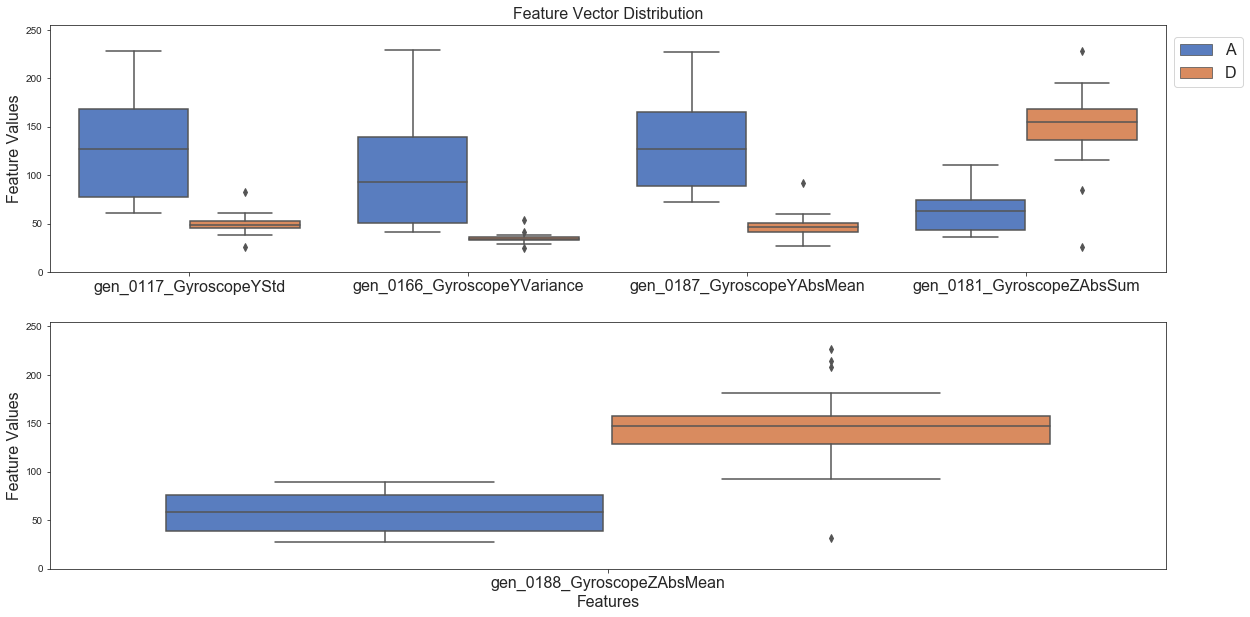

In [104]:
features, s = client.pipeline.execute()
client.pipeline.visualize_features(feature_vector=features)

## Generate model for A and D using RBF

In [ ]:
client.pipeline.set_classifier("PME", params={"distance_mode":"L1", "classification_mode":"RBF", "max_aif":156, "min_aif":5})
client.pipeline.set_validation_method("Recall")
client.pipeline.set_training_algorithm("RBF with Neuron Allocation Optimization", params={"number_of_iterations": 100,
                                "number_of_neurons": 128})
client.pipeline.set_tvo({'validation_seed':0})

r,s = client.pipeline.execute()
child_model_AD = r.configurations[0].models[0]
r.summarize()

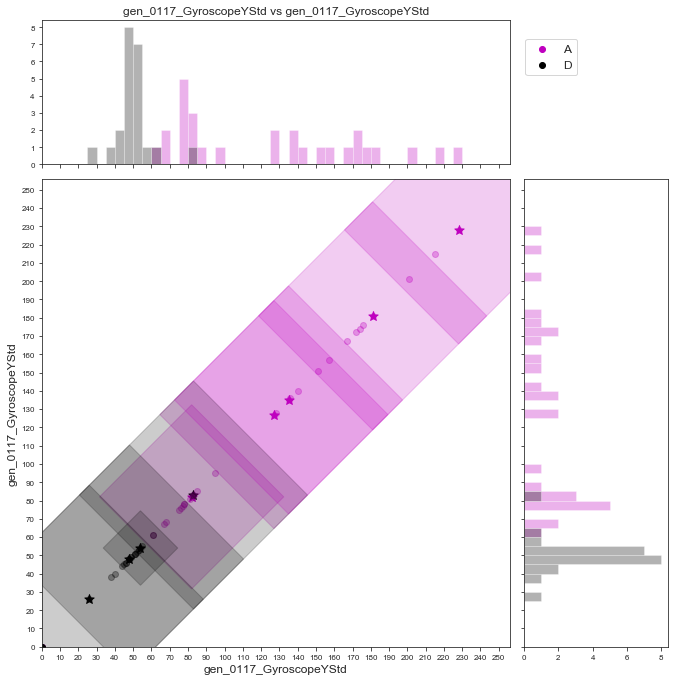

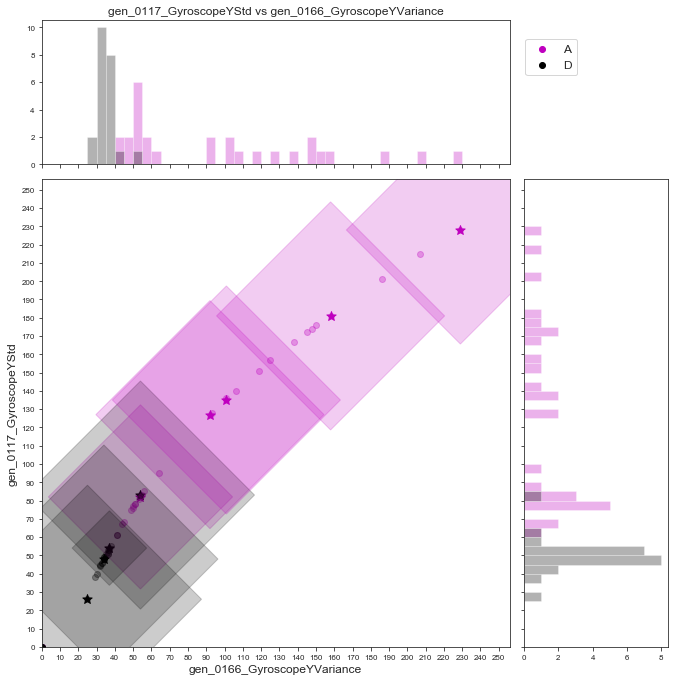

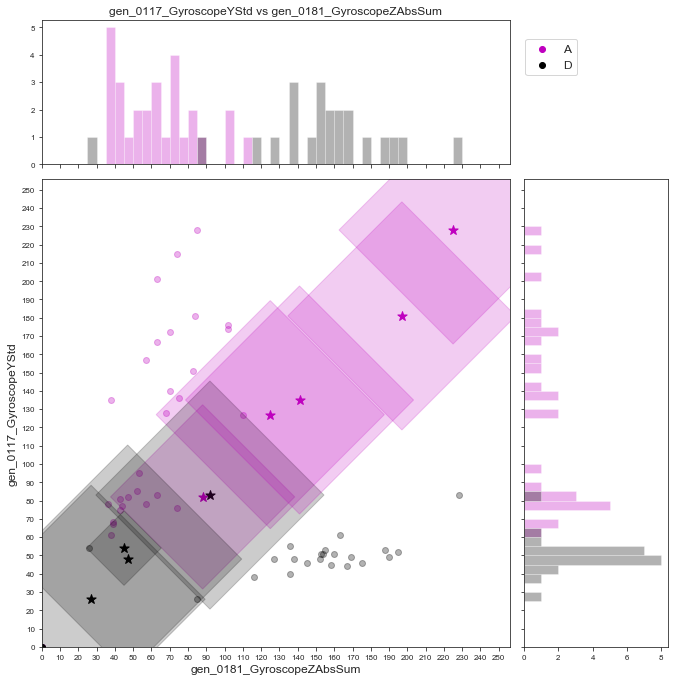

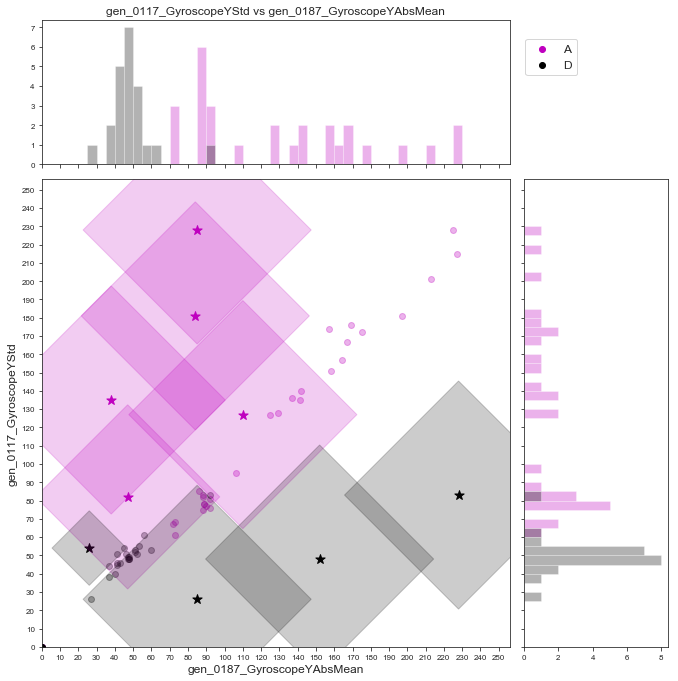

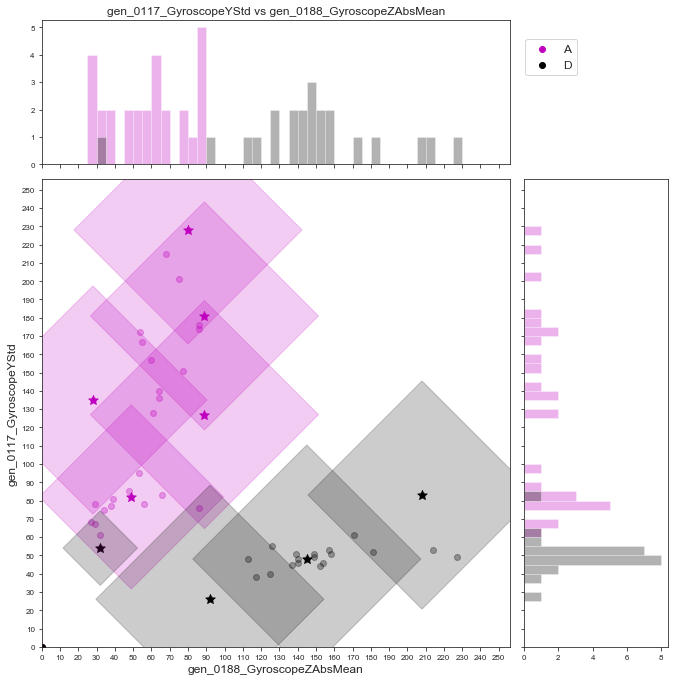

In [106]:
# a list of columns can also be passed in as the secon parameter to the visualize_neuron_array
client.pipeline.visualize_neuron_array(child_model_AD, features, pd.DataFrame(child_model_AD.knowledgepack.feature_summary).Feature.values[0], pd.DataFrame(child_model_AD.knowledgepack.feature_summary).Feature.values[0:])

In [107]:
child_model_AD.knowledgepack.save('AD')

# Create SubModel M,L,U

## Generate features for M,L,U events
Create a query for selecting only the M, L, and U events

In [ ]:
client.create_query(name="MLU",
                 segmenter=<Your Segmenter ID>,
                 label_column="My Auto Session",
                 metadata_columns=["Subject"],
                 columns=["AccelerometerX","AccelerometerY","AccelerometerZ","GyroscopeX","GyroscopeY","GyroscopeZ"],
                 metadata_filter="[Label] in [M,L,U]"
                )

In [ ]:
client.pipeline.reset(delete_cache=True)

client.pipeline.set_input_query("MLU")

client.pipeline.add_transform("Magnitude", params={"input_columns":[u'AccelerometerX', u'AccelerometerZ']}, overwrite=False)

client.pipeline.add_feature_generator([        {'subtype_call': 'Time', 'params': {'sample_rate': 100}},
                                            {'subtype_call': 'Rate of Change'},
                                            {'subtype_call': 'Statistical'},
                                            {'name':'Downsample with Min Max Scaling', 'params':{"columns": sensor_columns, "new_length": 9}},
                                            ],
                                            function_defaults={'columns': sensor_columns},
                                           )

client.pipeline.add_transform("Min Max Scale", params={"min_bound":0, "max_bound":255, "pad":2})

client.pipeline.add_feature_selector([{'name':'Information Gain', 'params':{"feature_number": 4, "target_sensor_weight": 0.9}},
                                   {'name':'Recursive Feature Elimination', 'params':{"method":"Log R", "number_of_features":5}}
                                  ],
                                  params = {"number_of_features":4})

features, s = client.pipeline.execute()
client.pipeline.visualize_features(feature_vector=features)

## Generate model for M,L,U using RBF

In [ ]:
client.pipeline.set_classifier("PME", params={"distance_mode":"L1", "classification_mode":"RBF", "max_aif":156, "min_aif":5})
client.pipeline.set_validation_method("Recall")
client.pipeline.set_training_algorithm("RBF with Neuron Allocation Optimization", params={"number_of_iterations": 100,
                                "number_of_neurons": 128})
client.pipeline.set_tvo({'validation_seed':0})

r,s = client.pipeline.execute()
child_model_MLU = r.configurations[0].models[0]
r.summarize()

In [ ]:
client.pipeline.visualize_neuron_array(child_model_MLU, features, pd.DataFrame(child_model_MLU.knowledgepack.feature_summary).Feature.values[0], pd.DataFrame(child_model_MLU.knowledgepack.feature_summary).Feature.values[0:])

In [ ]:
child_model_MLU.knowledgepack.save('MLU')

### Downloading the Knowledge Pack

This completes the model training portion of the tutorial.

1. We recommend using the **Download Model** page within the Analytics Studio at https://app.sensiml.cloud to download the Knowledge Pack model firmware.
2. Alternatively, see instructions for setting up the Knowledge Pack API at https://sensiml.com/documentation/sensiml-python-sdk/api-methods/knowledge-packs.html